In [65]:
import pandas as pd
import os 
import warnings 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
from src.sampler import Sampler 
from src.dataset import Dataset
from torch.utils.data import DataLoader
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
from src.classifier import Classifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
import pingouin

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
def get_lengths(df:pd.DataFrame, ref:bool=True, max_length:int=None):
    start_col, stop_col = ('ref_' if ref else '') +'start', ('ref_' if ref else '') + 'stop'
    lengths = df[stop_col] - df[start_col] 
    lengths = lengths // 3 + 1 # Convert to amino acid units. 
    if max_length is not None:
        lengths = lengths[lengths < max_length]
    return lengths

In [105]:
ref_out_df = load_ref_out()
ref_out_df = remove_partial(ref_out_df)

genome_metadata_df = load_genome_metadata()

pred_out_df = load_pred_out('../data/predict.out/filter_dataset_test.predict.csv', model_name='filter_balance_classes_and_lengths', ref_out_df=ref_out_df)

load_ref_out: 100%|██████████| 137/137 [00:06<00:00, 19.58it/s]


remove_partial: Removing 4364 instances marked as partial by both Prodigal and RefSeq from the DataFrame.


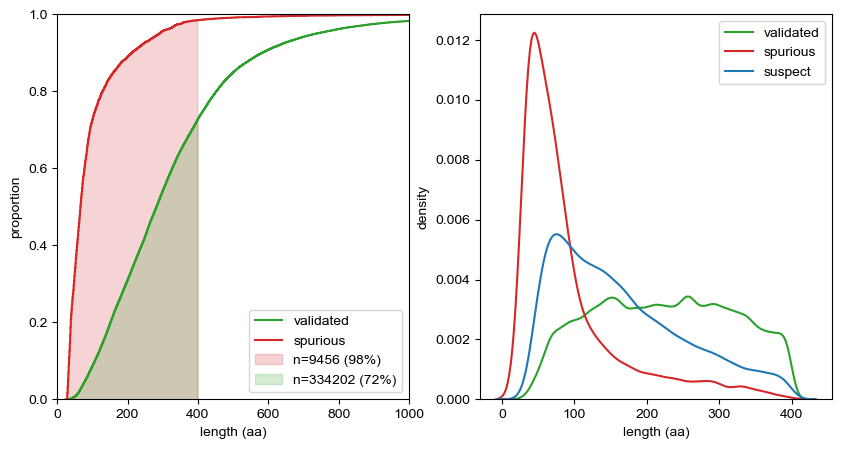

In [113]:
def figure_1(ref_out_df, path:str='../figures/filter-figure_1.png'):

    ref_out_0_df = ref_out_df[ref_out_df.ref_feature == 'CDS'].copy()
    ref_out_1_df = ref_out_df[ref_out_df.ref_feature != 'CDS'].copy()

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

    ax = axes[0]
    ax = sns.ecdfplot(ref_out_0_df.seq.apply(len), ax=ax, color='tab:green', label=f'validated')
    ax = sns.ecdfplot(ref_out_1_df.seq.apply(len), ax=ax, color='tab:red', label=f'spurious')

    x_0, y_0 = ax.get_lines()[0].get_data()
    x_1, y_1 = ax.get_lines()[1].get_data()

    x_0, x_1, y_0, y_1 = x_0[1:], x_1[1:], y_0[1:], y_1[1:]

    max_length = 400

    n_0 = (x_0 < max_length).sum()
    n_1 = (x_1 < max_length).sum()
    p_0 = int(n_0 * 100 / len(x_0))
    p_1 = int(n_1 * 100 / len(x_1))

    ax.fill_between(x_1[x_1 < max_length], y_1[x_1 < max_length], color='tab:red', alpha=0.2, label=f'n={n_1} ({p_1}%)')
    ax.fill_between(x_0[x_0 < max_length], y_0[x_0 < max_length], color='tab:green', alpha=0.2, label=f'n={n_0} ({p_0}%)')
    ax.set_xlim(0, 1000)
    ax.set_ylabel('proportion')
    ax.set_xlabel('length (aa)')
    ax.legend()

    ax = axes[1]
    sns.kdeplot(get_lengths(ref_out_0_df, max_length=max_length, ref=False), ax=ax, color='tab:green', label=f'validated')
    sns.kdeplot(get_lengths(ref_out_1_df, max_length=max_length, ref=False), ax=ax, color='tab:red', label=f'spurious')
    sns.kdeplot(get_lengths(get_suspect(ref_out_df), max_length=max_length, ref=False), ax=ax, color='tab:blue', label=f'suspect')
    ax.legend()
    ax.set_ylabel('density')
    ax.set_xlabel('length (aa)')

    plt.show()

figure_1(ref_out_df)

In [17]:
# The length distributions differ enough that I am a little worried that the model will take the "easy" way out and just
# learn sequence length. 
ref_out_0_df = ref_out_df[ref_out_df.ref_feature == 'CDS'].copy()
ref_out_1_df = ref_out_df[ref_out_df.ref_feature != 'CDS'].copy()

dataset_df = pd.concat([ref_out_1_df.assign(label=1), ref_out_0_df.assign(label=0)], axis=0)
dataset_df = dataset_df[dataset_df.seq.apply(len) < 400] # Only look at sequences shorter than 400 amino acids. 

train_dataset_df, test_dataset_df = train_test_split(dataset_df, test_size=0.2, train_size=0.8)

remove_suspect: Removing 7381 sequences which are marked as "hypothetical protein and have only ab initio evidence."


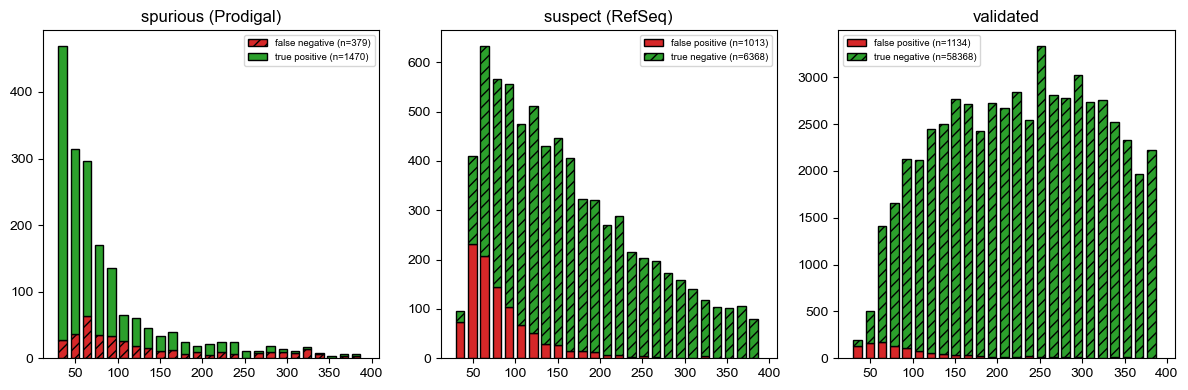

In [108]:
def figure_2(pred_out_df:pd.DataFrame, path:str=None):
    
    pred_out_0_df = pred_out_df[pred_out_df.label == 0] # Only look at the sequences which have a hit in the reference.
    pred_out_1_df = pred_out_df[pred_out_df.label == 1] # Only look at the sequences which have a hit in the reference.

    fig, axes = plt.subplots(figsize=(12, 4), ncols=3, layout='tight')

    bins = 25
    for ax, df in zip(axes, [pred_out_1_df, get_suspect(pred_out_0_df), remove_suspect(pred_out_0_df)]):
        lengths = list()
        for confusion_matrix, df_ in df.groupby('confusion_matrix', sort=True):
            lengths += [get_lengths(df_, ref=False)]

        labels = sorted(df.confusion_matrix.unique()) 
        _, bins, _ = ax.hist(lengths, stacked=True, bins=bins, width=10, label=sorted(df.confusion_matrix.unique()))
        apply_patch_settings(ax)
        ax.legend(labels=[f'{label} (n={(df.confusion_matrix == label).sum()})' for label in labels], fontsize='x-small')

    axes[0].set_title('spurious (Prodigal)')
    axes[1].set_title('suspect (RefSeq)')
    axes[2].set_title('validated')


    plt.show()

figure_2(pred_out_df)

# My new theory is that some of the suspect sequences in the set of "negative" training errors are also not real proteins, and 
# there are enough of them that it's confusing the model. 

remove_suspect: Removing 7381 sequences which are marked as "hypothetical protein and have only ab initio evidence."
R^2 = 0.12347522421197787
R^2 = 0.1266242321333917


/tmp/ipykernel_1919574/1647818668.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(df_.length[idxs], df_.model_output_1[idxs], s=2, color=color, label='suspect' if (is_suspect == 1) else 'validated', alpha=0.1)
/tmp/ipykernel_1919574/1647818668.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(df_.length[idxs], df_.model_output_1[idxs], s=2, color=color, label='suspect' if (is_suspect == 1) else 'validated', alpha=0.1)


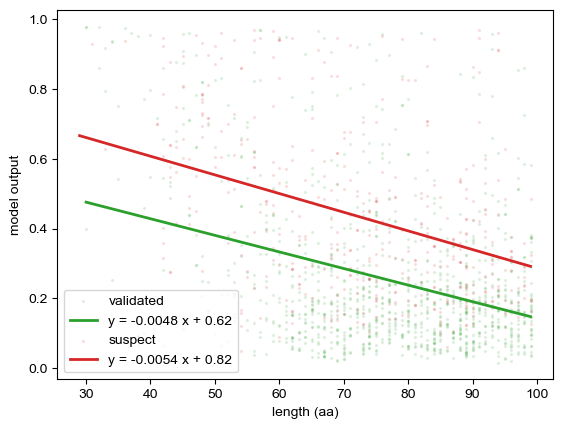

,Source,SS,DF,F,p-unc,np2
0,is_suspect,38.517986,1,911.986248,2.481567e-189,0.106903
1,length,45.620064,1,1080.141395,1.171108e-221,0.124166
2,Residual,321.790525,7619,NaN,NaN,NaN


In [134]:

max_length = 100

pred_out_0_df = pred_out_df[pred_out_df.label == 0].copy() # Get all predictions for sequences with a reference equivalent. 
pred_out_0_df = pd.concat([get_suspect(pred_out_0_df).assign(is_suspect=1), remove_suspect(pred_out_0_df).assign(is_suspect=0)], axis=0)
pred_out_0_df = pred_out_0_df.assign(length=get_lengths(pred_out_0_df, ref=False))
pred_out_0_df = pred_out_0_df[pred_out_0_df.length < max_length]

df = pd.DataFrame(index=pred_out_0_df.index)
df['length'] = pred_out_0_df.length # / pred_out_0_df.length.max()
df['is_suspect'] = pred_out_0_df.is_suspect
df['model_output_1'] = pred_out_0_df.model_output_1

# df.model_output_1 = (df.model_output_1 - df.model_output_1.mean()) - df.model_output_1.std()
# df.length = (df.length - df.length.mean()) - df.length.std()

fig, ax = plt.subplots()
for is_suspect, df_ in df.groupby('is_suspect'):
    linreg = LinearRegression()

    x, y = df_.length.values, df_.model_output_1.values
    linreg.fit(x.reshape(-1, 1), y)
    print('R^2 =', linreg.score(x.reshape(-1, 1), y))
    
    line = f'y = {linreg.coef_[0]:.4f} x + {linreg.intercept_:.2f}'
    color = 'tab:red' if (is_suspect == 1) else 'tab:green'

    idxs = np.random.choice(np.arange(len(df_)), len(df_) // 5)
    ax.scatter(df_.length[idxs], df_.model_output_1[idxs], s=2, color=color, label='suspect' if (is_suspect == 1) else 'validated', alpha=0.1)
    ax.plot(x, linreg.predict(x.reshape(-1, 1)), color=color, label=line, lw=2)

ax.legend()
ax.set_ylabel('model output')
ax.set_xlabel('length (aa)')
plt.show()

pingouin.ancova(df, dv='model_output_1', covar='length', between='is_suspect')

/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


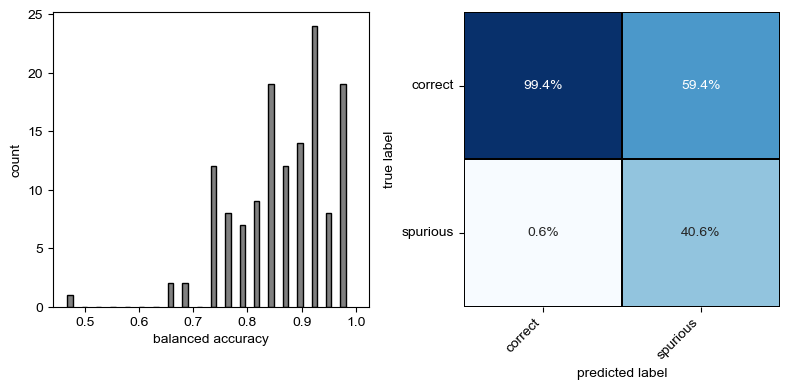

/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/prichter/miniconda3/envs/tripy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
118622 bytes written to file /tmp/tmpiw3dj38z/temp.png


,acc.,num. pred. false pos.,num. false pos.,num. pred. true pos.,num. true pos.
genome_id,,,,,
GCF_000968055.1,0.467822,13,1,190,202
GCF_002858925.1,0.658252,13,3,703,713
GCF_000184345.1,0.660215,6,6,310,310
GCF_000429345.1,0.699580,17,7,466,476
GCF_000183545.2,0.704365,16,9,329,336
...,...,...,...,...,...
GCF_000526195.1,0.989960,8,3,244,249
GCF_000755705.1,0.990494,6,1,258,263
GCF_001641825.1,0.992883,7,3,277,281


In [22]:
# First thing I want to look at is the accuracy per genome. 
fig, axes = plt.subplots(ncols=2, layout='tight', figsize=(8, 4))

ax = axes[0]
accs = pred_out_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label), include_groups=False)
ax.hist(accs, bins=20, color='gray', width=0.01, edgecolor='black')
ax.set_xlabel('balanced accuracy')
ax.set_ylabel('count')

ax = axes[1]
labels = ['correct', 'spurious']
matrix = confusion_matrix(pred_out_df.label.values, pred_out_df.model_label.values) #, labels=sorted(pred_out_df.label.unique()))
matrix = pd.DataFrame(matrix, columns=labels, index=labels)
matrix = matrix.apply(lambda x: x/x.sum(), axis=0) # Normalize the matrix.

sns.heatmap(matrix, ax=ax, annot=True, cbar=False, linecolor='black', lw=0.2, fmt='.1%', cmap='Blues') # fmt='.1%',

# Rotate the tick labels on the x-axis of each subplot.
ax.set_xticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(labels)) + 0.5, matrix.columns, rotation=0)
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')

plt.show()

# The UserWarning from scikitlearn is because some of the genomes have no Prodigal false positives in the testing set. 

def table_1(pred_out_df:pd.DataFrame, path:str='../figures/filter-table_1.png'):
    table_df = dict()

    table_df['acc.'] = pred_out_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label) , include_groups=False)
    
    table_df['num. pred. false pos.'] = pred_out_df.groupby('genome_id').apply(lambda df : (df.model_label == 1).sum(), include_groups=False)
    table_df['num. false pos.'] = pred_out_df.groupby('genome_id').apply(lambda df : (df.label == 1).sum(), include_groups=False)
    table_df['num. pred. true pos.'] = pred_out_df.groupby('genome_id').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    table_df['num. true pos.'] = pred_out_df.groupby('genome_id').apply(lambda df : (df.label == 0).sum(), include_groups=False)
    table_df = pd.DataFrame(table_df)
    
    table_df = table_df.sort_values('acc.')
    dfi.export(table_df.iloc[:50], path)
    return table_df


table_1(pred_out_df)

/home/prichter/Documents/tripy/notebooks/utils.py:45: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, nan, rRNA, tRNA, ncRNA, misc_feature, misc_RNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')
/home/prichter/Documents/tripy/notebooks/utils.py:45: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, misc_RNA, misc_feature, ncRNA, rRNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')
/home/prichter/Documents/tripy/notebooks/utils.py:45: UserWarning: check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: CDS, misc_feature, misc_RNA, rRNA, tRNA
  warnings.warn(f'check_cds: Not all entries in the input DataFrame correspond to CDS features. Found: {features}')


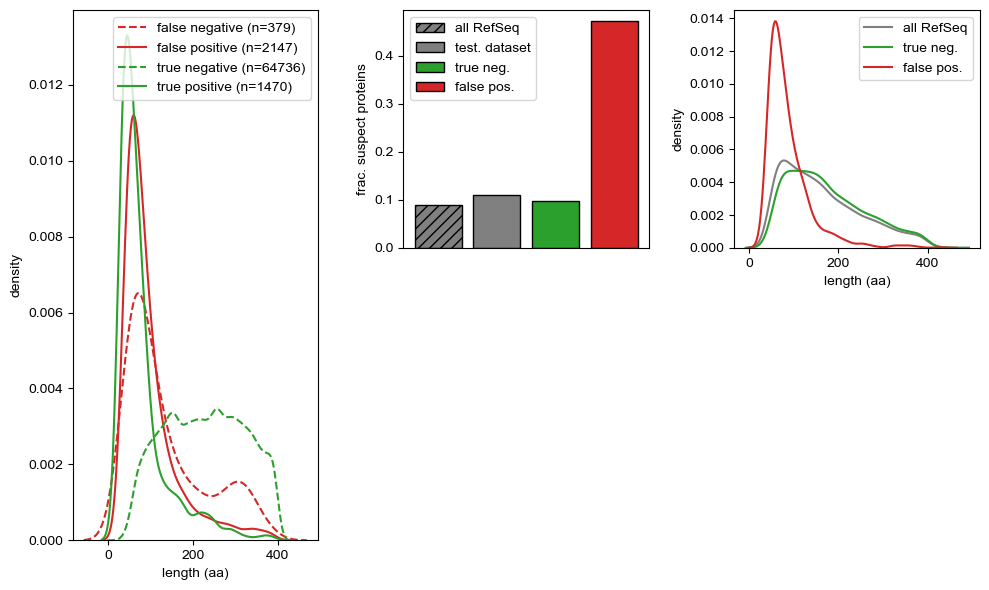

In [26]:
# I am mainly worried about the things that the model has predicted to be wrong, but are actually correct. 
# It does seem to have mainly just learned length. 
def figure_3(pred_out_df:pd.DataFrame, ref_out_df:pd.DataFrame, path:str=None, model_name:str='filter_balance_classes_and_lengths'):

    fig = plt.figure(layout='tight', figsize=(10, 6))
    grid = GridSpec(nrows=2, ncols=3, figure=fig)

    ax_a = fig.add_subplot(grid[:, 0])
    ax_b = fig.add_subplot(grid[0, 1])
    ax_c = fig.add_subplot(grid[0, 2])

    labels = []
    for confusion_matrix, df in pred_out_df.groupby('confusion_matrix'):
        sns.kdeplot(df.seq.apply(len), label=confusion_matrix, ax=ax_a)
        labels.append(f'{confusion_matrix} (n={len(df)})')
    apply_line_settings(ax_a)
    ax_a.legend(labels=labels)
    ax_a.set_ylabel('density')
    ax_a.set_xlabel('length (aa)')
    
    labels = ['all RefSeq', 'test. dataset', 'true neg.', 'false pos.']
    positions = np.arange(len(labels))
    heights = list()
    heights += [get_frac_suspect(ref_out_df)]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.ref_feature == 'CDS'])]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.confusion_matrix == 'true negative'])]
    heights += [get_frac_suspect(pred_out_df[pred_out_df.confusion_matrix == 'false positive'])]
    ax_b.bar(positions, heights, label=labels, color=['gray', 'gray', 'tab:green', 'tab:red'], edgecolor='black', hatch=['///', None, None, None])
    ax_b.set_ylabel('frac. suspect proteins')
    ax_b.set_xticks([])
    ax_b.legend()

    sns.kdeplot(get_lengths(get_suspect(pred_out_df)), color='gray', ax=ax_c, label='all RefSeq')
    sns.kdeplot(get_lengths(get_suspect(pred_out_df[pred_out_df.confusion_matrix == 'true negative'])), color='tab:green', ax=ax_c, label='true neg.')
    sns.kdeplot(get_lengths(get_suspect(pred_out_df[pred_out_df.confusion_matrix == 'false positive'])), color='tab:red', ax=ax_c, label='false pos.')
    ax_c.legend()
    ax_c.set_ylabel('density')
    ax_c.set_xlabel('length (aa)')
    plt.show()


figure_3(pred_out_df, ref_out_df)
    # Does this have something to do with the truncation sizes of the false positives versus true positives, or is it really just length?

    # for confusion_matrix in ['false positive', 'true negative']:
    #     df = pred_out_df[pred_out_df.confusion_matrix == confusion_matrix]
    #     diffs = [((row.ref_stop - row.ref_start) - (row.stop - row.stop)) // 3 for row in df.itertuples()]
    #     ref_lengths = [(row.ref_stop - row.ref_start) // 3 for row in df.itertuples()] 
    #     lengths = [(row.stop - row.start) // 3 for row in df.itertuples()] 
    #     ax.scatter(lengths, df.filter_balance_classes_and_lengths_output_1,  s=5, **kwargs[confusion_matrix])
    # ax.set_xscale('log')

In [ ]:
# Not sure if the problem is length or the fact that the reference proteins aren't real... 
# How reliable are the labels? Should I discard the suspect proteins from the positive testing set?

fig, ax = plt.subplots()

pred_out_1_df = pred_out_df[pred_out_df.filter_balance_classes_and_lengths_label == 1]


ref_feature
CDS             2122
rRNA              16
tRNA               6
misc_feature       2
misc_RNA           1
Name: count, dtype: int64

In [ ]:
pred_out_df[pred_out_df.confusion_matrix == 'false positive'].ref_product.value_counts()
pred_out_df[pred_out_df.confusion_matrix == 'true negative'].ref_product.value_counts()

pred_out_fp_df = pred_out_df[pred_out_df.confusion_matrix == 'false positive']
pred_out_tn_df = pred_out_df[pred_out_df.confusion_matrix == 'true negative']

pred_out_df[(pred_out_df.ref_product == 'hypothetical protein') & pred_out_df.ref_seq.isnull()][['ref_pseudo', 'ref_product', 'partial', 'ref_evidence_type', 'ref_partial']]
pred_out_fp_df[(pred_out_fp_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')
pred_out_tn_df[(pred_out_tn_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')

ref_evidence_type
ab initio prediction      6368
similar to AA sequence    3647
protein motif              202
profile                     14
Name: count, dtype: int64

In [ ]:
get_ab_initio(pred_out_df).ref_product.value_counts() / len(get_ab_initio(pred_out_df))

ref_product
hypothetical protein                                            0.889170
helix-turn-helix domain-containing protein                      0.001927
putative integral inner membrane protein                        0.001325
conserved protein of unknown function; phage SPbeta             0.001084
alpha/beta hydrolase                                            0.001084
                                                                  ...   
PseG/SpsG family protein                                        0.000120
putative efflux transporter; prophage 1 region                  0.000120
ubiquitin carboxyl-terminal hydrolase family protein            0.000120
putative glycosyltransferase (complex carbohydrate synthase)    0.000120
efflux RND transporter periplasmic adaptor subunit              0.000120
Name: count, Length: 645, dtype: float64

In [ ]:
# What is the length distribution of hypothetical proteins versus Prodigal errors?

In [ ]:
train_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0)
test_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0)

x_train, y_train = train_df.seq.apply(len).values, train_df.label.values
x_test, y_test = test_df.seq.apply(len).values, test_df.label.values

model = LogisticRegression(class_weight='balanced', C=0.001, tol=1e-8)
model.fit(x_train.reshape(-1, 1), y_train)

y_test_pred = model.predict(x_test.reshape(-1, 1))
y_train_pred = model.predict(x_train.reshape(-1, 1))

print('Balanced test accuracy:', balanced_accuracy_score(y_test, y_test_pred.ravel()))
print('Balanced train accuracy:', balanced_accuracy_score(y_train, y_train_pred.ravel()))

Balanced test accuracy: 0.7958396559282479
Balanced train accuracy: 0.7948956639028347


In [56]:
model.n_iter_

array([18], dtype=int32)